<a href="https://colab.research.google.com/github/TranMyLinh-297/QA_Law_VN/blob/master/Knowledge_Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Link tham khao: Knowledge Graph – A Powerful Data Science Technique to Mine Information from Text (with Python code)](https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/?fbclid=IwAR2hPyAAGqnwFclYMBPb_ifLpHagtRPsqWy75RJkihVjvZgHucsS6aeqCa8)

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

doc = nlp("Sơn Tùng is a single")

for tok in doc:
  print(tok.text, "...", tok.dep_)

Sơn ... compound
Tùng ... nsubj
is ... ROOT
a ... det
single ... attr


In [ ]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_sm")

from spacy.matcher import Matcher
from spacy.tokens import Span

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline


# Entities Extraction

In [ ]:
candidate_sentences = pd.read_csv("/content/wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

In [ ]:
candidate_sentences.head()

,sentence
0,"confused and frustrated, connie decides to leave on her own."
1,"later, a woman’s scream is heard in the distance."
2,christian is then paralyzed by an elder.
3,the temple is set on fire.
4,"outside, the cult wails with him."


In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')
doc = nlp("the film had 200 patents")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
film ... nsubj
had ... ROOT
200 ... nummod
patents ... dobj


In [ ]:
doc = nlp("bộ phim đã có 200 bằng sáng chế")

for tok in doc:
  print(tok.text, "...", tok.dep_)

bộ ... ROOT
phim ... pobj
đã ... nsubj
có ... ROOT
200 ... nummod
bằng ... compound
sáng ... compound
chế ... ROOT


#Entity Pairs Extraction

The main idea is to go through a sentence and extract the subject and the object as and when they are encountered.

A function below to extract the subject and the object (entities) from a sentence while also overcoming the challenges are multiple words.

In [ ]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [ ]:
get_entities ("the film had 200 patents")

['film', '200  patents']

try in Vietnamese

In [ ]:
get_entities ("bộ phim đã có 200 bằng sáng chế")

['đã', 'phim']

get a list entity in data

In [ ]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:42<00:00, 100.81it/s]


In [ ]:
entity_pairs[10:20]

[['we', 'tests'],
 ['m global', 'international sales rights'],
 ['robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['', 'military  arrest'],
 ['train', 'vuk'],
 ['telepath', 'gallio'],
 ['singer', 'men']]

#Relation / Predicate Extraction

In [ ]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [ ]:
get_relation("John completed the task")

'completed'

get a list relation in data

In [ ]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]


100%|██████████| 4318/4318 [00:40<00:00, 107.52it/s]


In [ ]:
pd.Series(relations).value_counts()[:50]

is               370
was              297
released on       87
include           73
are               71
were              71
released          40
's                38
composed by       35
have              31
became            31
has               31
become            29
released in       27
included          26
called            22
produced          22
considered        20
made              20
had               20
be                18
been              18
scheduled         17
used              17
stars             16
directed by       16
written by        15
set               14
produced by       14
wrote             14
hired             14
went              13
introduced in     13
received          13
wanted            12
began in          11
won               11
began             11
features          10
gave              10
sold              10
reported           9
includes           9
known as           9
used in            9
shot in            9
gives              9
produced in  

#Build a Knowledge Graph

In [ ]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [ ]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

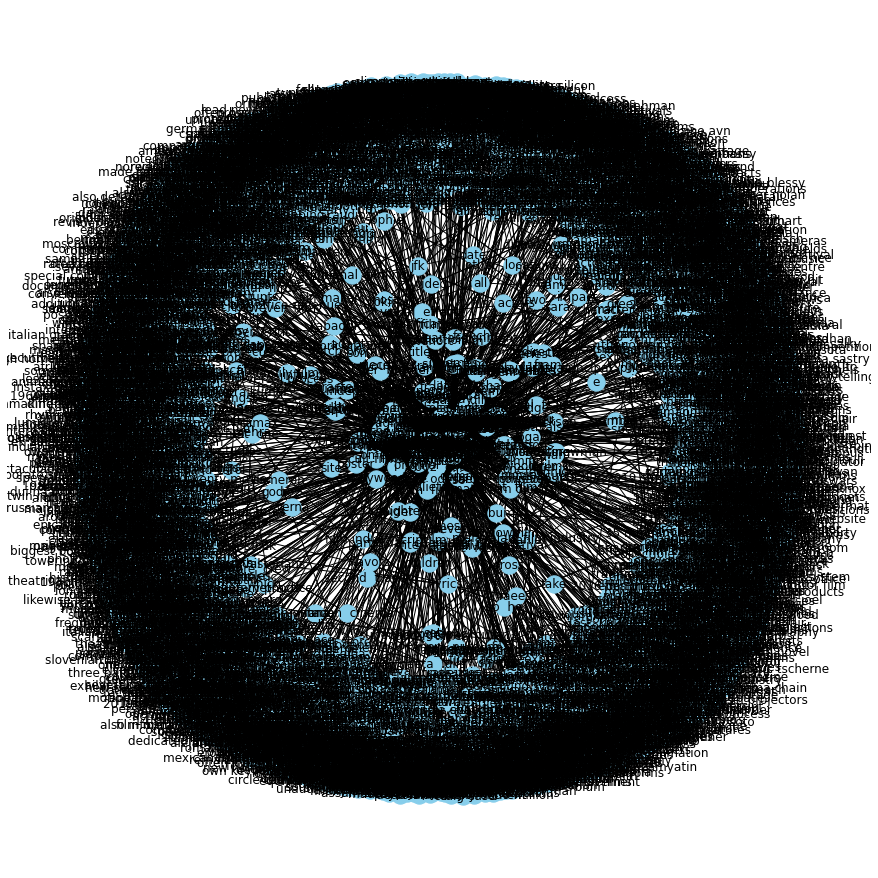

In [ ]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

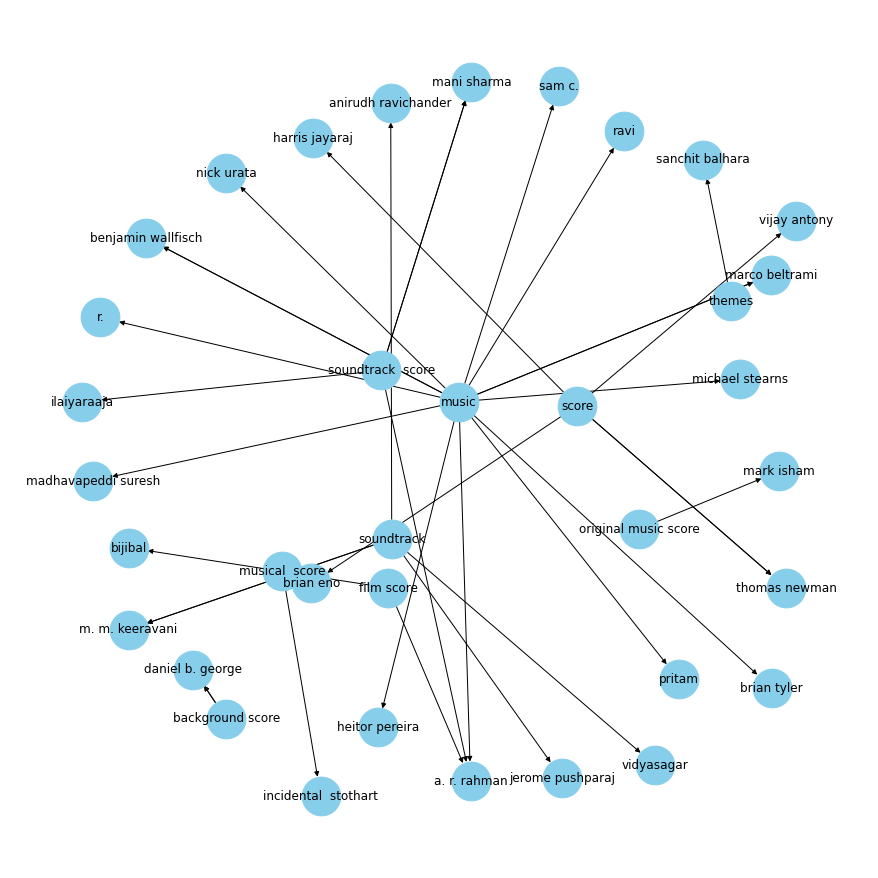

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

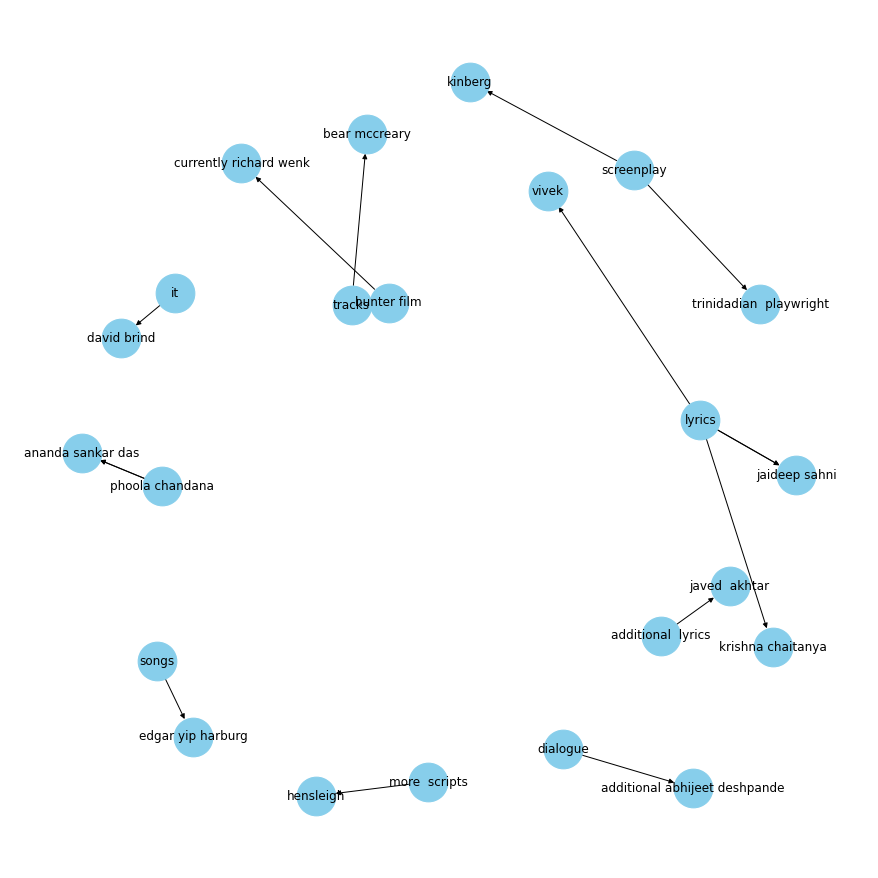

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()